In [2]:
from matplotlib import pyplot
from matplotlib.image import imread
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, Dense, Flatten, InputLayer, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

In [5]:
import numpy as np
import pandas as pd

In [6]:
from google.colab import drive

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
pwd

'/content'

In [9]:
cd drive/"My Drive"/Colab_Notebooks

/content/drive/My Drive/Colab_Notebooks


In [10]:
batch_size = 32

GPU Resources: https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/gpu.ipynb#scrollTo=IqR2PQG4ZaZ0

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [13]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15286893437255029703
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15330967552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7318611471729537953
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
 xla_global_id: 416903419]

In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [15]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(1,))
  predictions = tf.keras.layers.Dense(1)(inputs)
  model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.2))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [16]:
tf.debugging.set_log_device_placement(True)

gpus = tf.config.list_logical_devices('GPU')
if gpus:
  # Replicate your computation on multiple GPUs
  c = []
  for gpu in gpus:
    with tf.device(gpu.name):
      a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
      b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
      c.append(tf.matmul(a, b))

  with tf.device('/CPU:0'):
    matmul_sum = tf.add_n(c)

  print(matmul_sum)

tf.Tensor(
[[ 44.  56.]
 [ 98. 128.]], shape=(2, 2), dtype=float32)


### Augmentation Configurations

In [17]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

### Generator Configuration

In [19]:
train_generator = train_datagen.flow_from_directory(
        'dataset_dogs_vs_cats/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical') 

Found 18819 images belonging to 2 classes.


In [20]:
test_generator = test_datagen.flow_from_directory(
        'dataset_dogs_vs_cats/test',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False) 

Found 6355 images belonging to 2 classes.


In [21]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [22]:
from tensorflow.keras.applications import inception_v3
inception_conv = inception_v3.InceptionV3(weights=None, include_top=False)
inception_conv.summary()
inputs = Input(shape=(150,150,3),name = 'image_input')  # our input shape: (32,32,3)
output_inception = inception_conv(inputs) # using functional api syntax
#Add the fully-connected layers 
x = Flatten(name='flatten')(output_inception)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)
my_model = Model(inputs=inputs, outputs=x)  # Using the Functional API

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [23]:
inputs = Input(shape=(150,150,3,1),name = 'image_input')  # our input shape: (32,32,3)

In [24]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [25]:
my_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy', 'mse',f1_m,precision_m, recall_m])

In [26]:
import math
from math import floor

In [27]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [28]:
my_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy', 'mse',f1_m,precision_m, recall_m])

In [30]:
HISTORY = my_model.fit_generator(train_generator, 
                        epochs=20, 
                        verbose=True, 
                        callbacks=[keras.callbacks.EarlyStopping(patience=8, verbose=1,restore_best_weights=True),
                              keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)],
                       shuffle=True
                        )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
589/589 [==============================] - 4480s 8s/step - loss: 0.8362 - accuracy: 0.4983 - mse: 0.2615 - f1_m: 0.4986 - precision_m: 0.4986 - recall_m: 0.4986 - lr: 0.0010
Epoch 2/20
589/589 [==============================] - 146s 248ms/step - loss: 0.6984 - accuracy: 0.5069 - mse: 0.2515 - f1_m: 0.5067 - precision_m: 0.5067 - recall_m: 0.5067 - lr: 0.0010
Epoch 3/20
589/589 [==============================] - 146s 248ms/step - loss: 0.6963 - accuracy: 0.5092 - mse: 0.2506 - f1_m: 0.5094 - precision_m: 0.5094 - recall_m: 0.5094 - lr: 0.0010
Epoch 4/20
589/589 [==============================] - 148s 251ms/step - loss: 0.6811 - accuracy: 0.5717 - mse: 0.2431 - f1_m: 0.5713 - precision_m: 0.5713 - recall_m: 0.5713 - lr: 0.0010
Epoch 5/20
589/589 [==============================] - 148s 251ms/step - loss: 0.6405 - accuracy: 0.6421 - mse: 0.2240 - f1_m: 0.6421 - precision_m: 0.6421 - recall_m: 0.6421 - lr: 0.0010
Epoch 6/20
589/589 [==============================] - 145s 247ms/st

dict_keys(['loss', 'accuracy', 'mse', 'f1_m', 'precision_m', 'recall_m', 'lr'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Unrecognized location 'middle right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if sys.path[0] == '':


<Figure size 432x288 with 0 Axes>

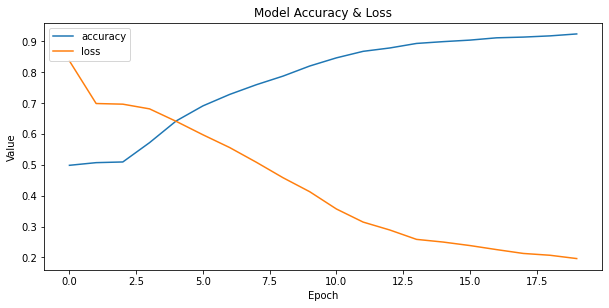

In [73]:
print(HISTORY.history.keys())
plt.figure(1)

# summarize history for accuracy
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(HISTORY.history['accuracy'])
plt.plot(HISTORY.history['loss'])
plt.title('Model Accuracy & Loss')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='middle right')

# summarize history for loss
#plt.subplot(212)
#plt.plot(HISTORY.HISTORY['loss'])
#plt.plot(HISTORY.HISTORY['val_loss'])
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()  

In [31]:
prediction_list = my_model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [32]:
from sklearn.metrics import confusion_matrix


In [33]:
len(prediction_list)

6355

In [ ]:
print(prediction_list[:10])

In [ ]:
#sum(1 for _ in test_generator)

In [35]:
def make_confusion_matrix(model, prediction_list, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    #pred_labels = [lambda x: x for x in prediction_list if x >= threshold]
    y_labels = test_generator.classes
    fraud_confusion = confusion_matrix(y_labels, new_pred_labels)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['cat', 'dog'],
           yticklabels=['cat', 'dog']);
    plt.xlabel('prediction')
    plt.ylabel('actual')


In [38]:
new_pred_labels = []
for item in prediction_list:
  if item[0] > item[1]:
    new_pred_labels.append(0)
  else:
    new_pred_labels.append(1)


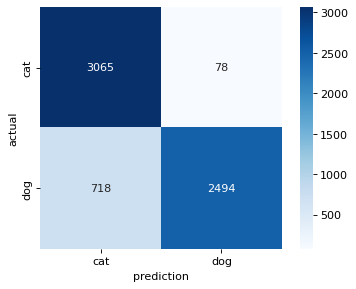

In [39]:
make_confusion_matrix(my_model,prediction_list)

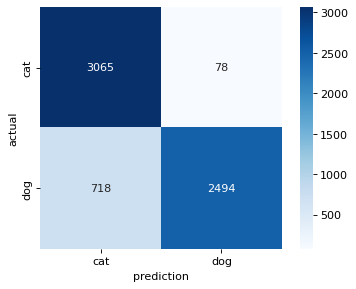

In [52]:
make_confusion_matrix(my_model,prediction_list,threshold=0.8)

In [74]:
pwd

'/content/drive/MyDrive/Colab_Notebooks'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [78]:
personal_generator = test_datagen.flow_from_directory(
        'Personal_tests',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False) 

Found 0 images belonging to 0 classes.


In [ ]:
#print(prediction_list[:10])
#print(actual_labels[:10])
#print(pred_labels[:10])
#print(new_pred_labels[:10])
#print(pred_labels[:10])

In [44]:
actual_labels = test_generator.classes

In [46]:
pred_labels = prediction_list >= 0.5

In [47]:
incorrects = np.nonzero(pred_labels != actual_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [48]:
print(incorrects)

(array([0]),)


In [49]:
indices = [i for i,v in enumerate(new_pred_labels) if new_pred_labels[i] != actual_labels[i]]
subset_of_wrongly_predicted = [new_pred_labels[i] for i in indices]

In [50]:

print(indices)

[29, 37, 114, 189, 200, 219, 265, 289, 384, 491, 493, 525, 563, 568, 620, 625, 660, 845, 896, 995, 1025, 1086, 1092, 1121, 1153, 1158, 1197, 1229, 1247, 1279, 1308, 1317, 1318, 1351, 1387, 1495, 1607, 1629, 1646, 1651, 1658, 1683, 1729, 1792, 1805, 1842, 1870, 1909, 1942, 1947, 2021, 2077, 2102, 2112, 2120, 2141, 2158, 2179, 2205, 2337, 2360, 2457, 2554, 2618, 2686, 2702, 2734, 2740, 2826, 2831, 2839, 2941, 2997, 3002, 3035, 3055, 3101, 3106, 3143, 3149, 3154, 3161, 3175, 3177, 3191, 3195, 3203, 3216, 3217, 3218, 3223, 3235, 3238, 3240, 3255, 3256, 3260, 3269, 3276, 3285, 3289, 3300, 3304, 3317, 3318, 3319, 3329, 3334, 3335, 3338, 3349, 3351, 3361, 3364, 3366, 3368, 3370, 3374, 3377, 3381, 3386, 3398, 3400, 3404, 3407, 3409, 3410, 3428, 3435, 3438, 3439, 3447, 3453, 3461, 3462, 3468, 3474, 3477, 3481, 3482, 3484, 3488, 3491, 3492, 3493, 3496, 3498, 3506, 3513, 3533, 3535, 3540, 3543, 3548, 3560, 3561, 3568, 3577, 3581, 3583, 3584, 3589, 3590, 3591, 3592, 3593, 3603, 3606, 3620, 3622, 3

In [51]:
print(len(indices))

796


folder = '**test**/"

In [ ]:
pwd

In [53]:
folder = 'test1/'

In [59]:
def load_image(index):
  filename = folder + str(index+1)+'.jpg'
  image = imread(filename)
  pyplot.imshow(image)

In [54]:
def load_images(image_list):
  for index in image_list:
    pyplot.subplot(330 + 1 + index)
    filename = folder + str(index+1)+'.jpg'
    image = imread(filename)
    pyplot.imshow(image)
  pyplot.tight_layout()
  pyplot.show()

In [58]:
load_images(indices[1:10].astype(np.float))

AttributeError: ignored

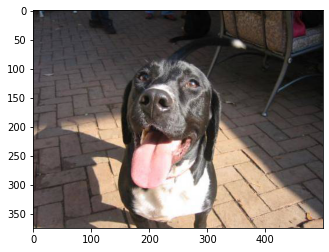

In [61]:
load_image(indices[29])

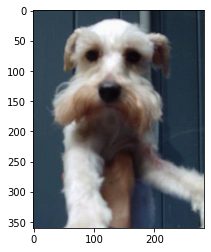

In [62]:
load_image(indices[37])

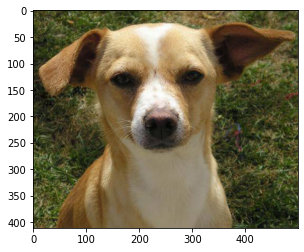

In [63]:
load_image(indices[114])

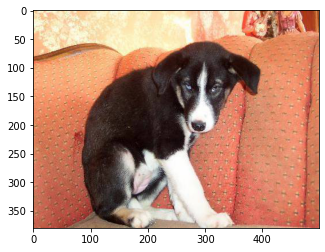

In [64]:
load_image(indices[189])

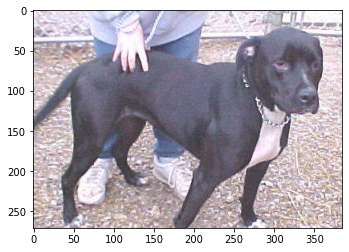

In [65]:
load_image(indices[200])

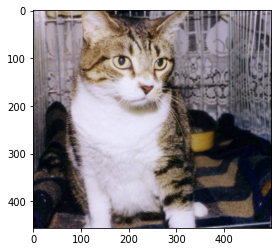

In [66]:
load_image(indices[219])

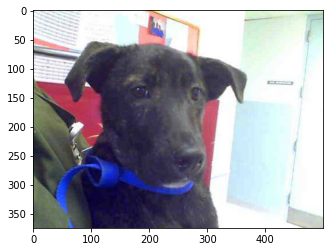

In [67]:
load_image(indices[265])

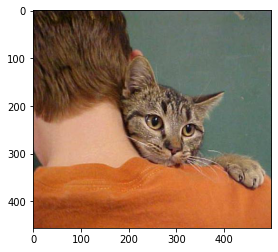

In [68]:
load_image(indices[289])

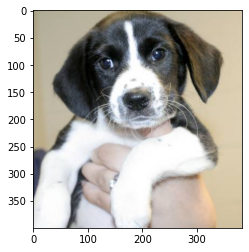

In [69]:
load_image(indices[384])

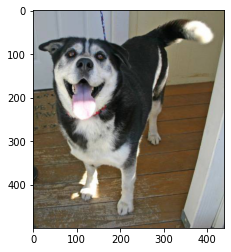

In [70]:
load_image(indices[491])

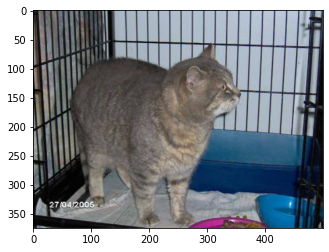

In [71]:
load_image(indices[493])